# Package Calling

In [1]:
import sys

sys.path.append("../../")

In [2]:
import datetime as dtt
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

## Package Settings

In [3]:
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

In [4]:
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
pd.set_option("display.float_format", lambda x: "%.3f" % x)
pd.set_option("chained_assignment", None)

In [5]:
plt.rcParams["font.family"] = ["Arial Unicode MS"]  # Chinese Labels
plt.rcParams["axes.unicode_minus"] = False  # Minus Sign
plt.rcParams["figure.max_open_warning"] = 0

sns.set(
    style="darkgrid",
    rc={
        "figure.figsize": (12, 6),
        "font.sans-serif": ["Arial Unicode MS", "Arial"],
    },
)

## GC Settings

In [6]:
import gc

gc.isenabled()
gc.get_threshold()

True

(700, 10, 10)

In [7]:
# gc.set_threshold(10,1,1)
# gc.enable()
# gc.disable()

# Modeling

In [8]:
data_path = "/Users/chenzhou/Documents/Everything/python/COVID19/data/data_0516_SH.csv"
data_sh = pd.read_csv(
    data_path,
    dtype={
        "inbound_confirmed": int,
        "inbound_asymp": int,
        "outbound_confirmed": int,
        "outbound_asymp": int,
        "cure": int,
        "relieve": int,
    },
    parse_dates=["date"],
)

In [9]:
data_sh["confirmed_add"] = data_sh.inbound_confirmed + data_sh.outbound_confirmed
data_sh["asymp_add"] = data_sh.inbound_asymp + data_sh.outbound_asymp
data_sh["total_add"] = data_sh.confirmed_add + data_sh.asymp_add

data_sh["confirmed_acc"] = data_sh.confirmed_add.cumsum() - 380
data_sh["asymp_acc"] = data_sh.asymp_add.cumsum() - 120
data_sh["total_affected"] = data_sh.confirmed_acc + data_sh.asymp_acc

data_sh = data_sh.loc[data_sh.date >= "2022-03-01"].reset_index(drop=True)

In [10]:
data_sh

,inbound_confirmed,inbound_asymp,outbound_confirmed,outbound_asymp,date,cure,relieve,confirmed_add,asymp_add,total_add,confirmed_acc,asymp_acc,total_affected
0,1,1,37,17,2022-03-01,8,1,38,18,56,95,5,100
1,3,5,39,19,2022-03-02,8,2,42,24,66,137,29,166
2,2,14,43,21,2022-03-03,9,1,45,35,80,182,64,246
3,3,16,24,10,2022-03-04,12,0,27,26,53,209,90,299
4,0,28,25,10,2022-03-05,8,4,25,38,63,234,128,362
5,3,45,32,16,2022-03-06,65,16,35,61,96,269,189,458
6,4,51,36,10,2022-03-07,27,10,40,61,101,309,250,559
7,3,62,26,10,2022-03-08,32,7,29,72,101,338,322,660
8,4,76,42,16,2022-03-09,18,13,46,92,138,384,414,798
9,11,64,32,10,2022-03-10,17,7,43,74,117,427,488,915


## Optimize BS Pars Locally

In [11]:
from covid19 import bs_coeff_local_opt, model_theta_global_opt, revise_ser

In [12]:
bs_interp_prop = 0.5
interg_interp_prop = 500.0
ser = data_sh.total_affected.iloc[28:].values
kappa, mu, tau = 0.6, 1.0, 1.8

In [13]:
labd, lr, decay, iters, early_stop_ratio, early_stop_steps, show_process = (
    5.0,
    0.02,
    0.999,
    int(4e2),
    [1.1, 0.999],
    3,
    True,
)

(array([-0.00446955, -0.02432212, -0.03494476]),
 68058.29120741376,
 array([ 15376.31169674,  21397.46164228,  29452.87244041,  38484.56721497,
         48816.4146564 ,  61039.11971463,  75428.88681095,  92125.7471299 ,
        111039.53943756, 131982.09287213, 154603.39047879, 178505.95167099,
        203264.2874284 , 228455.482859  , 253694.92801782, 278628.26564876,
        302983.84430399, 326546.91527311, 349247.63498685, 371075.28348042,
        392110.73006575, 412466.8503139 , 432292.95555588, 451682.5675312 ,
        470469.61385363, 488395.12155845, 505088.10949306, 520210.83140963,
        533670.48886754, 545470.40741557, 555753.4607531 , 564694.50198214,
        572456.7536646 , 579201.4289486 , 585093.33386703, 590290.15717353,
        594917.52561976, 599079.21563602, 602823.66436898, 606175.28633889,
        609117.7448439 , 611638.92453552, 613784.34670082, 615617.39810663,
        617215.29080334, 618657.11470465, 620015.64589403, 621362.74765928,
        622772.9459

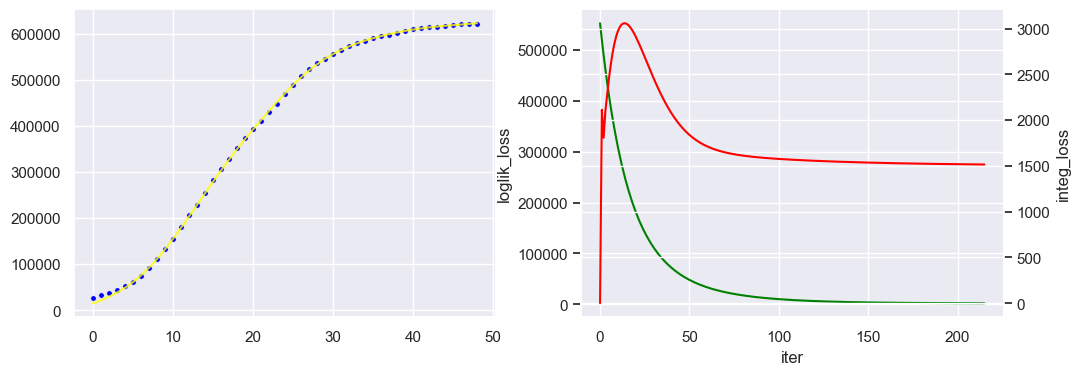

In [14]:
bs_coeff_local_opt(
    ser,
    kappa,
    mu,
    tau,
    bs_interp_prop,
    interg_interp_prop,
    labd,
    lr,
    decay,
    iters,
    early_stop_ratio,
    early_stop_steps,
    show_process,
    ser_loss_expansion=0.5,
)

## Optimize Theta Globally

In [15]:
kappa_init, mu_init, tau_init = 0.59, 1.0, 1.81

inter 0: Theta: [0.59060356 1.00278527 1.81354436] Loss: 63562.973801590124
inter 1: Theta: [0.59082545 1.00629384 1.81727524] Loss: 49748.02322857234


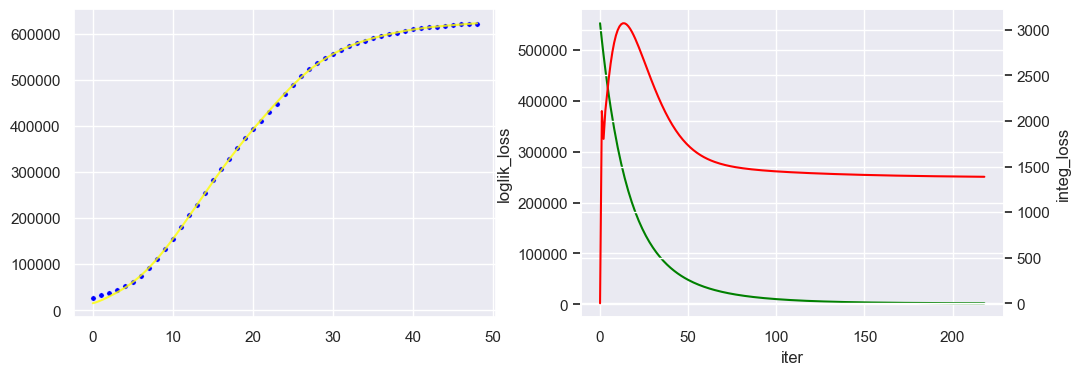

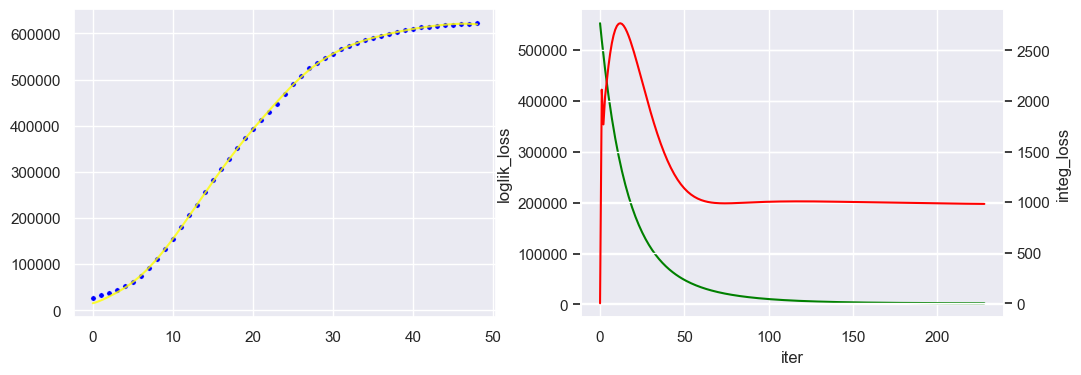

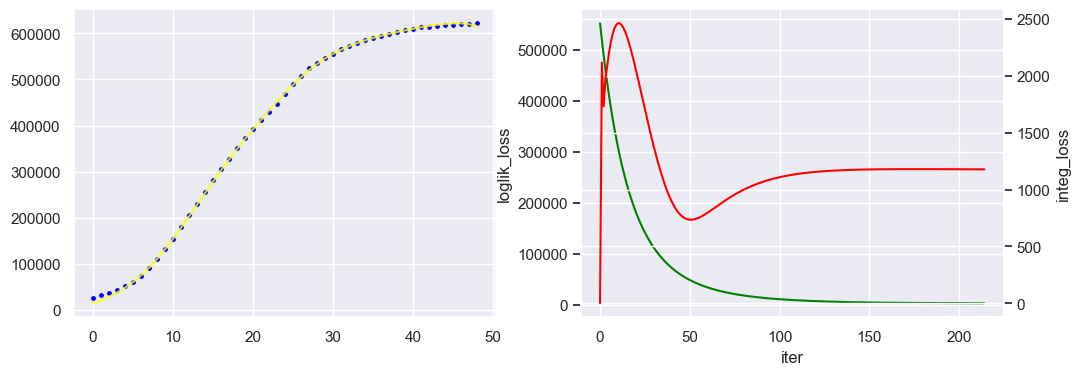

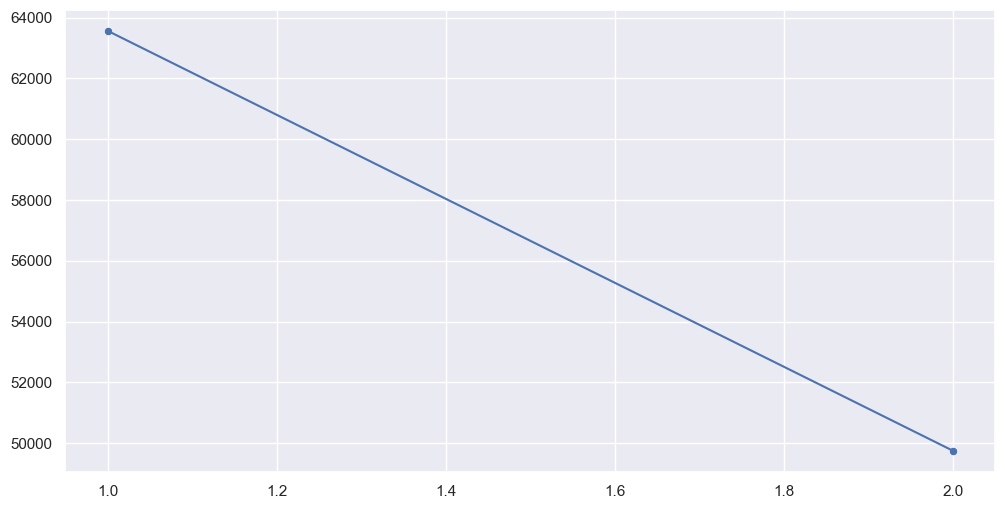

In [16]:
ser = data_sh.total_affected.iloc[28:].values

theta_opt, losses, fitted_opt = model_theta_global_opt(
    ser,
    kappa_init=kappa_init,
    mu_init=mu_init,
    tau_init=tau_init,
    bs_interp_prop=0.5,
    interg_interp_prop=500.0,
    labd=5.0,
    bs_lr_schedule=(int(4e2), 0.02, 0.999),
    theta_lr_schedule=(int(2e2), 0.1, 0.99),
    early_stop_ratio=[1.2, 0.999],
    early_stop_steps=3,
    show_process="both",
)

<AxesSubplot:>

<AxesSubplot:>

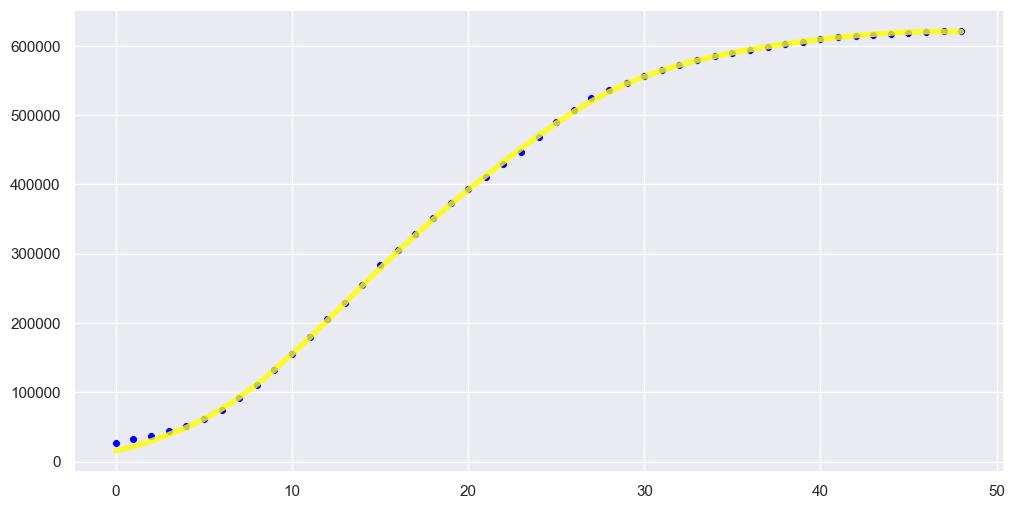

In [17]:
sns.scatterplot(x=range(len(ser)), y=ser, alpha=1.0, color="blue", s=32)
sns.lineplot(
    x=range(len(ser)), y=revise_ser(fitted_opt), alpha=0.8, color="yellow", linewidth=4
)

# Application on SZ

In [18]:
data_sz = pd.read_csv(
    "/Users/chenzhou/Documents/Everything/python/COVID19/data/covid19_shenzhen.csv",
    dtype={
        "week_group": int,
        "adt": int,
        "imputed_adt": float,
        "adt_prop": float,
        "store_cnt": int,
        "cfm_cases": pd.Int64Dtype(),
        "asym_cases": pd.Int64Dtype(),
        "covid_group": int,
    },
    parse_dates=["date"],
)
# data_sz.fillna(0, inplace=True)
data_sz["total_add"] = data_sz.cfm_cases + data_sz.asym_cases

In [19]:
data_modeling = data_sz.loc[data_sz.covid_group.eq(2)]
shifting = 0
data_modeling["total_affected"] = data_modeling.total_add.cumsum() + shifting

In [20]:
data_modeling

,date,week_group,adt,imputed_adt,adt_prop,store_cnt,cfm_cases,asym_cases,covid_group,total_add,total_affected
1161,2022-03-07,166,5559,5559.000,1.000,238,19,0,2,19,19
1162,2022-03-08,166,7257,7257.000,1.000,235,13,0,2,13,32
1163,2022-03-09,166,6194,6194.000,1.000,236,6,0,2,6,38
1164,2022-03-10,166,6484,6484.000,1.000,239,15,0,2,15,53
1165,2022-03-11,166,6309,6309.000,1.000,241,9,2,2,11,64
1166,2022-03-12,166,3101,9998.623,0.310,233,27,2,2,29,93
1167,2022-03-13,166,1700,9658.631,0.176,213,60,6,2,66,159
1168,2022-03-14,167,698,7530.603,0.093,182,75,11,2,86,245
1169,2022-03-15,167,463,7776.377,0.060,162,39,21,2,60,305
1170,2022-03-16,167,161,7867.639,0.020,102,55,37,2,92,397


(array([0.0034034409655563924, 0.008823488449286654, -0.13902943511927043],
       dtype=object),
 71.12090789543282,
 array([7.570018677729052, 25.897519633884222, 43.91740435269819,
        62.445759809045136, 82.37197530702124, 104.07624178687372,
        125.82865440423173], dtype=object))

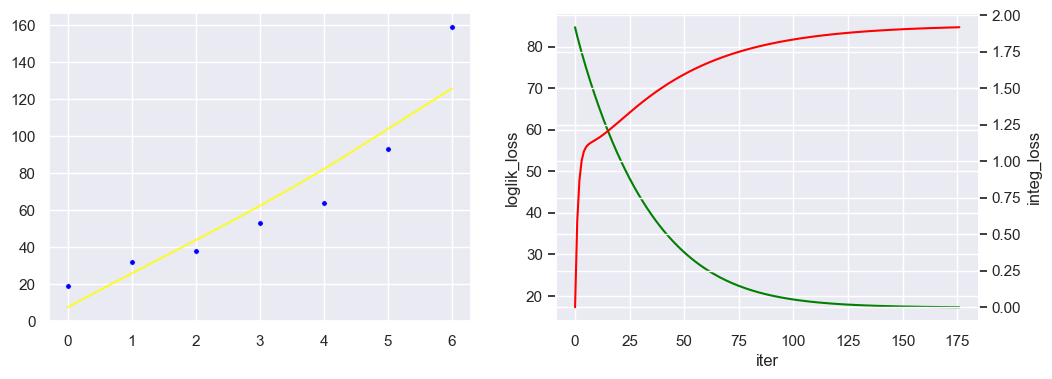

In [21]:
ser = data_modeling.total_affected.iloc[:7].values
kappa_init, mu_init, tau_init = 0.7, 1.0, 1.3

bs_coeff_local_opt(
    ser,
    kappa=kappa_init,
    mu=mu_init,
    tau=tau_init,
    bs_interp_prop=0.5,
    interg_interp_prop=500.0,
    labd=5.0,
    lr=0.02,
    decay=0.999,
    iters=int(4e2),
    early_stop_ratio=[1.2, 0.9999],
    early_stop_steps=3,
    show_process=True,
    ser_loss_expansion=0.1
)

inter 0: Theta: [0.71997644 0.76493177 1.42996342] Loss: 22.352421237071713
inter 1: Theta: [0.71994791 0.7701908  1.42995288] Loss: 22.476924343066464
inter 2: Theta: [0.7199122  0.77591589 1.42996548] Loss: 22.670353603109305
inter 3: Theta: [0.71986639 0.78228077 1.42999769] Loss: 22.927380473670294
inter 4: Theta: [0.71980444 0.78964397 1.43004188] Loss: 23.29351069626953


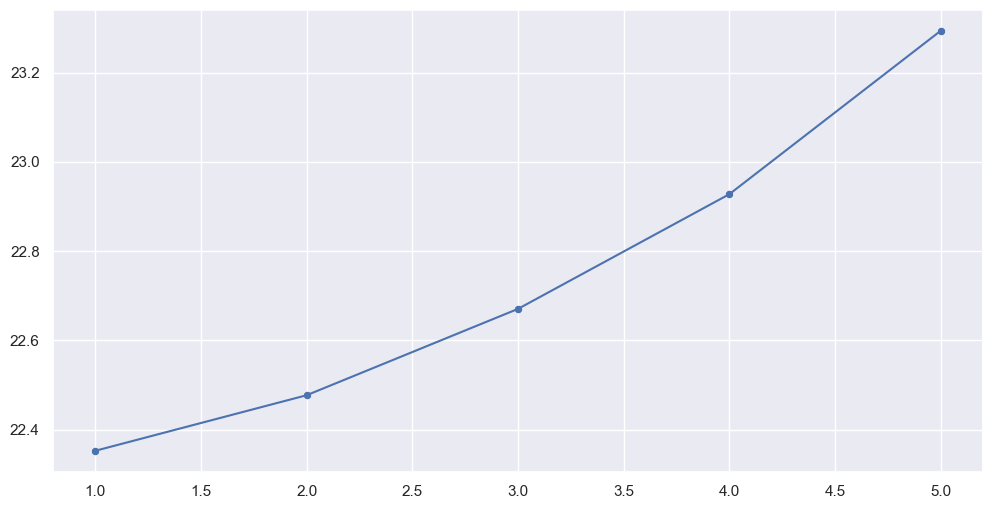

In [22]:
kappa_init, mu_init, tau_init = 0.72, 0.76, 1.43

theta_opt, losses, fitted_opt = model_theta_global_opt(
    ser,
    kappa_init=kappa_init,
    mu_init=mu_init,
    tau_init=tau_init,
    bs_interp_prop=0.5,
    interg_interp_prop=200.0,
    labd=5.0,
    bs_lr_schedule=(int(4e2), 0.02, 0.999),
    theta_lr_schedule=(int(2e2), 0.01, 0.99),
    early_stop_ratio=[1.2, 0.999],
    early_stop_steps=3,
    show_process="outer",
)

<AxesSubplot:>

<AxesSubplot:>

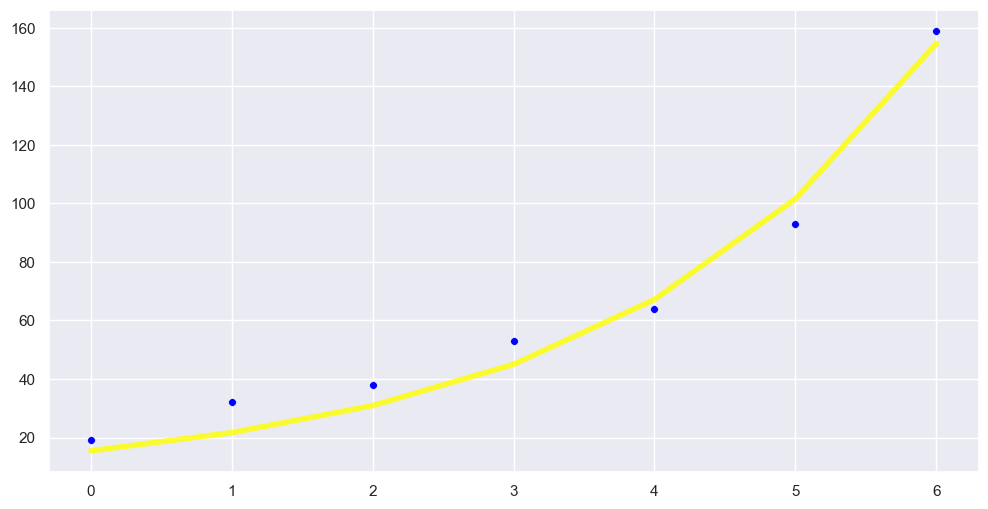

In [23]:
sns.scatterplot(x=range(len(ser)), y=ser, alpha=1.0, color="blue", s=32)
sns.lineplot(
    x=range(len(ser)), y=revise_ser(fitted_opt), alpha=0.8, color="yellow", linewidth=4
)

## Prediction